# Test tigerpy with simple linear regression

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

## Simulate data

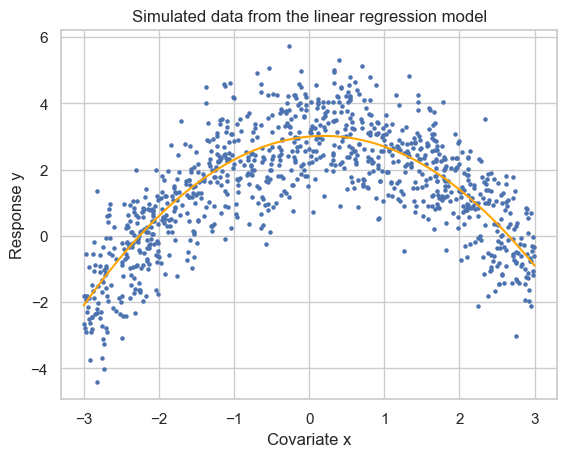

In [2]:
rng = np.random.default_rng(42)
# Sample size and true parameters
n = 1000
true_beta = np.array([3.0, 0.2, -0.5])
true_sigma = 1.0

# Data-generating process
x0 = rng.uniform(size=n, low=-3, high=3)
X_mat = np.column_stack((np.ones(n), x0, x0**2))
eps = rng.normal(scale=true_sigma, size=n)
response_vec = X_mat @ true_beta + eps

# Data to plot the linear regression line
x_plot = np.linspace(-3, 3, num=200)
X_plot = np.column_stack([np.ones(200), x_plot, x_plot**2])

# Set the seaborn theme
sns.set_theme(style="whitegrid")
# Plot the simulated data
plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, X_plot @ true_beta, color="orange")
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# Set up design matrix 
X = tiger.Obs(name="X_loc")
X.fixed(data = np.column_stack((x0, x0**2)))

# Set up hyperparameters
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)

# Use paramter param_space="positive" to transform sigma into unconstrained space  
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta=beta)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
jnp.sum(m.log_lik)

Array(-3246.6587, dtype=float32)

In [5]:
m.log_prior

Array(-23.544468, dtype=float32)

In [6]:
m.log_prob

Array(-3270.2031, dtype=float32)

In [7]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [8]:
graph.logprob()

Array(-3270.2031, dtype=float32)

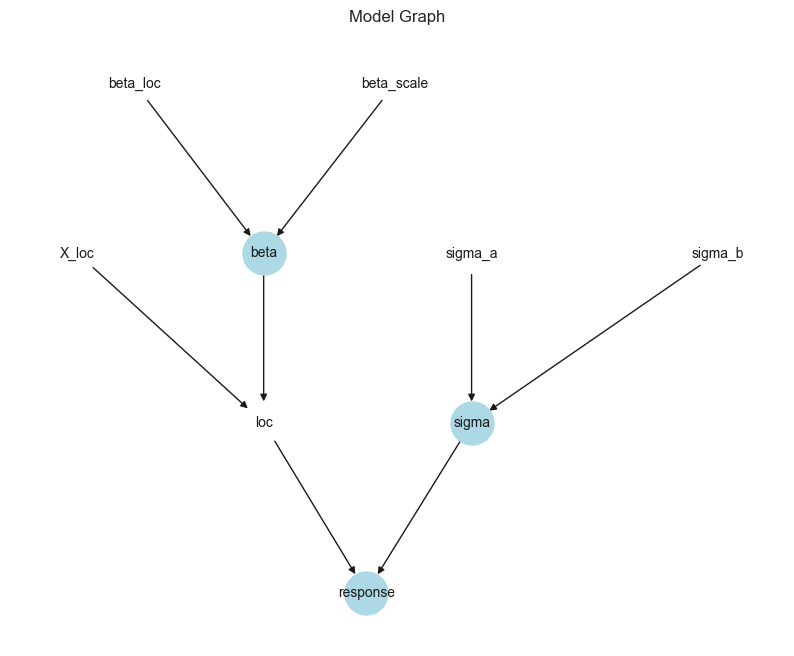

In [10]:
graph.visualize_graph()

## Inference with BBVI

### Run bbvi

In [11]:
q = bbvi.Bbvi(graph=graph)

In [12]:
q.run_bbvi(step_size=0.05,
           threshold=1e-2,
           key_int=1,
           batch_size=256,
           num_var_samples=64,
           chunk_size=50,
           epochs=250)

Start optimization ...
Finished optimization.


In [19]:
q.trans_var_params

{'beta': {'loc': Array([ 2.9455328 ,  0.25354534, -0.5099645 ], dtype=float32),
  'cov': Array([[ 1.0885149e-03, -3.6453289e-06, -1.0036383e-05],
         [-3.6453287e-06,  3.5964439e-04,  5.5564675e-07],
         [-1.0036384e-05,  5.5564675e-07,  1.4521343e-04]], dtype=float32)},
 'sigma': {'loc': Array([1.0241499], dtype=float32),
  'cov': Array([[0.00074897]], dtype=float32)}}

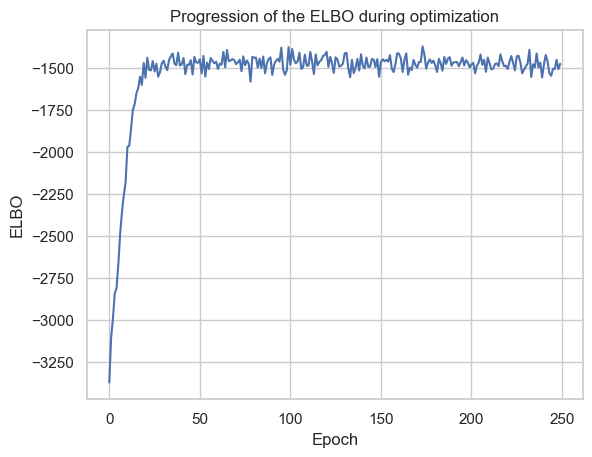

In [13]:
q.plot_elbo()

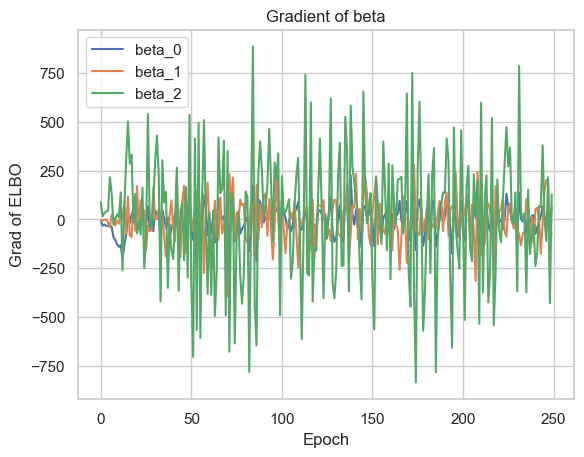

In [14]:
plot_grad_beta = np.vstack([d["beta"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta[:,0], label="beta_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta[:,1], label="beta_1")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta[:,2], label="beta_2")
plt.title("Gradient of beta")
plt.xlabel("Epoch")
plt.ylabel("Grad of ELBO")
plt.legend()
plt.show()

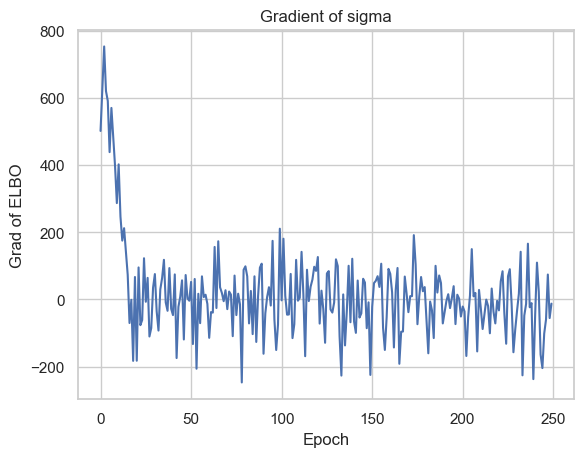

In [15]:
plot_grad_beta = np.vstack([d["sigma"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta[:,0])
plt.title("Gradient of sigma")
plt.xlabel("Epoch")
plt.ylabel("Grad of ELBO")
plt.show()

In [16]:
# plot the regression line 
b = q.trans_var_params["beta"]["loc"]
x_new = jnp.linspace(x0.min(), x0.max(), num=200)
X_new = tiger.Obs(name="X_pred")
X_new.fixed(data = np.column_stack([x_new, x_new**2]))
y = X_new.design_matrix @ b

In [17]:
# Data to plot the linear regression line
x_plot = np.linspace(-3, 3, num=200)
X_plot = np.column_stack([np.ones(200), x_plot, x_plot**2])

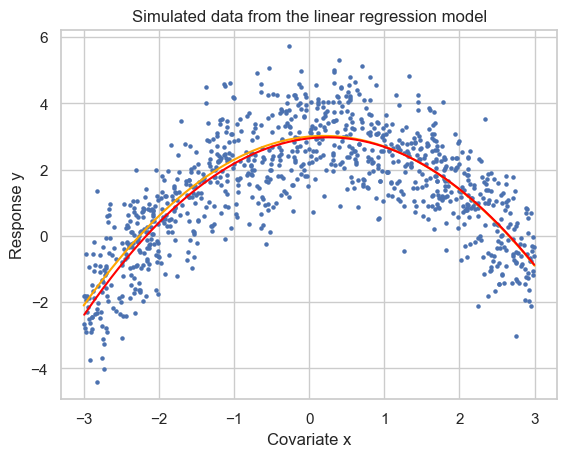

In [18]:
# plot the data
fig, ax = plt.subplots()

plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, X_plot @ true_beta, color ="orange")
plt.plot(x_new, y, color = "red")
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()